U ovoj svesci, biće prikazan model koji klasifikuje samo 5 od 6 datih klasa. Klasa toxic se može izbaciti, s obzirom na to da se svi komentari svakako mogu smatrati toksičnim. Ideja je proveriti da li će izbacivanje instanci koje pripadaju samo klasi toxic uticati na poboljšanje predviđanja. Klasa toxic zauzima većinu skupa, dakle vršimo undersampling.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import pickle
import sklearn
import time
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import multilabel_confusion_matrix
from skmultilearn.model_selection import iterative_train_test_split
from keras.utils.vis_utils import plot_model
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# da moze da koristi funkcije definisane u svesci SharedFunctions

%run SharedFunctions.ipynb

Učitava se prethodno pripremljen skup podataka: 

In [3]:
data = pd.read_csv('data/data_longer.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
labels = ['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
data = data[data['target'] == 1]

In [5]:
data.shape

(22468, 9)

Brišu se svi komentari koji su pripadali samo klasi toxic, a nijednoj od ostalih 5

In [6]:
mask = (data['severe_toxic']==0) & (data['obscene']==0) & (data['threat']==0) & (data['insult']==0) & (data['identity_hate']==0)
data = data.drop(data[mask].index)

data.shape

(15092, 9)

**Dakle, broj instanci za višelabelarnu klasifikaciju je 15092.**

In [7]:
# Broj komentara po klasama: 

get_label_counts(data, labels)

{'severe_toxic': 1962,
 'obscene': 12140,
 'threat': 689,
 'insult': 11304,
 'identity_hate': 2117}

Klase severe_toxic, identity_hate i threat (ova klasa posebno mali broj instanci) su i dalje u manjini.

### 1. Podela na trening, test, i validacioni skup

Koristi se iterative_train_test_split iz paketa skmultilearn.model_selection za stratifikovanu podelu:

In [8]:
X = data['comment_text']
y = data[labels]

X_train, y_train, X_test, y_test = iterative_train_test_split(
                                                        np.asmatrix(X).T, np.asmatrix(y), test_size = 0.33)

#X_train, y_train, X_validation, y_validation = iterative_train_test_split(
#                                            X_train_validation, y_train_validation, test_size = 0.2)

In [9]:
X_test.shape, X_train.shape

((4947, 1), (10145, 1))

In [10]:
X_train = pd.DataFrame(X_train, columns=['comment_text'])['comment_text']
X_test = pd.DataFrame(X_test, columns=['comment_text'])['comment_text']
#X_train_validation = pd.DataFrame(X_train_validation, columns=['comment_text'])['comment_text']
#X_validation = pd.DataFrame(X_validation, columns=['comment_text'])['comment_text']

y_train = pd.DataFrame(y_train, columns=labels)[labels]
y_test = pd.DataFrame(y_test, columns=labels)[labels]
#y_train_validation = pd.DataFrame(y_train_validation, columns=labels)[labels]
#y_validation = pd.DataFrame(y_validation, columns=labels)[labels]

### 2. Priprema teksta

Koraci su isti kao u prethodnoj svesci (u slučaju binarne klasifikacije).

In [11]:
# uzima se recimo 20000 najfrekventinijh reci
max_features = 20000

# max duzina
max_len = 100

In [12]:
word_index, tokenizer = get_vocabulary(max_features, X_train, 'tokenizer_multi_undersample.pickle')

In [13]:
print('Broj jedinstvenih reci:', len(word_index))

Broj jedinstvenih reci: 25568


In [14]:
X_train_transformed = to_sequence(X_train, max_len, tokenizer)
X_test_transformed = to_sequence(X_test, max_len, tokenizer)
#X_validation_transformed = to_sequence(X_validation, max_len, tokenizer)
#X_train_validation_transformed = to_sequence(X_train_validation, max_len, tokenizer)

In [15]:
X_train_transformed.shape, X_test_transformed.shape

((10145, 100), (4947, 100))

In [16]:
# kreiranje matrice ugnjezdjavanja

embedding_dim = 100
embedding_matrix = create_embedding_matrix(word_index, embedding_dim)

### 3. Formiranje modela

In [17]:
# parametri izabrani isprobavanjem

kernel_size = 3
pool_size = 4
filters = 64
dropout_rate = 0.2
embedding_dim = 100
lr = 0.01
layers = 0

In [18]:
multi_model = create_model(num_of_classes = 5, num_of_features = max_features, embedding_dim = embedding_dim, 
                           kernel_size = kernel_size, pool_size = pool_size, filters = filters, 
                           dropout_rate = dropout_rate, maxlen = max_len, lr = lr, 
                           embedding_matrix = embedding_matrix, layers=layers)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 64)           19264     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 128)           24704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 128)            0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 128)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0

### 4. Obučavanje modela

In [19]:
# i ovde se koriste tezine pri klasifikaciji, zbog nebalansiranih klasa

weights = get_weights(data[labels].to_numpy(), 5)
weights

{0: 1.5384301732925587,
 1: 0.2486326194398682,
 2: 4.380841799709724,
 3: 0.2670205237084218,
 4: 1.42579121398205}

In [20]:
epochs = 20
batch_size = 64

In [21]:
start = time.time()    

multi_history = multi_model.fit(X_train_transformed, y_train, batch_size=batch_size, epochs=epochs, 
                                validation_split=0.2,
                                class_weight=weights, verbose=False)
                                 
print('Trajanje obucavanja modela multilabel klasifikacije: ', time.time() - start)

Trajanje obucavanja modela multilabel klasifikacije:  51.44335222244263


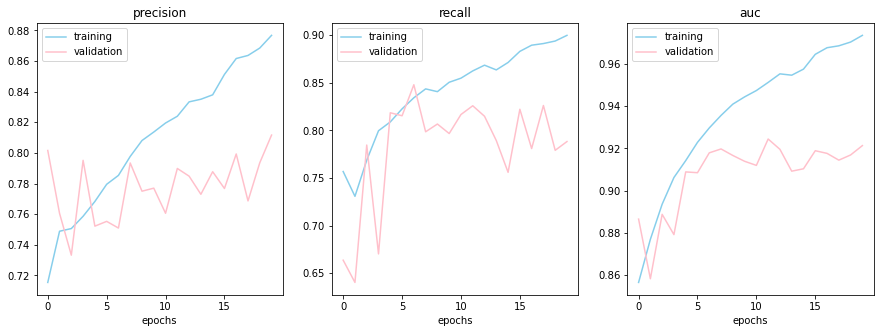

In [22]:
plot_graphs(multi_history, ['precision', 'recall', 'auc'])

### 5. Evaluacija modela

In [23]:
scores = multi_model.evaluate(X_train_transformed, y_train)
print('Train Loss: ', scores[0])
print('Train Precision: ', scores[1])
print('Train Recall: ', scores[2])
print('Train AUC:', scores[3])
print('Train F1: ', scores[4])

318/318 [==============================] - 1s 3ms/step - loss: 0.2167 - precision: 0.8921 - recall: 0.8862 - auc: 0.9717 - f1_m: 0.8880
Train Loss:  0.21672455966472626
Train Precision:  0.892054557800293
Train Recall:  0.8861556649208069
Train AUC: 0.9716739058494568
Train F1:  0.8879572749137878


In [24]:
scores = multi_model.evaluate(X_test_transformed, y_test)
print('Test Loss: ', scores[0])
print('Test Precision: ', scores[1])
print('Test Recall: ', scores[2])
print('Test AUC:', scores[3])
print('Test F1: ', scores[4])

155/155 [==============================] - 1s 3ms/step - loss: 0.4962 - precision: 0.8029 - recall: 0.7718 - auc: 0.9106 - f1_m: 0.7858
Test Loss:  0.49617356061935425
Test Precision:  0.8028830289840698
Test Recall:  0.7718337178230286
Test AUC: 0.9106020331382751
Test F1:  0.7857958674430847


Predviđanje:

In [25]:
y_predicted = multi_model.predict(X_test_transformed)

In [26]:
# Prag se postavlja na 0.4 za zastupljenije klase, i 0.2 za manje zastupljene
# jer nam je cilj da maksimuzujemo odziv
# Bolje da imamo vise lazno pozitivnih nego lazno negativnih

def translate(array):
    
    res1 = [1 if x>0.2 else 0 for x in array[::2]]
    res2 = [1 if x>0.4 else 0 for x in array[1::2]]

    res = [res1[0], res2[0], res1[1], res2[1], res1[2]]
        
    return res


result = map(translate, y_predicted)

In [27]:
y_labels = list(result)
cf = multilabel_confusion_matrix(y_test, y_labels)

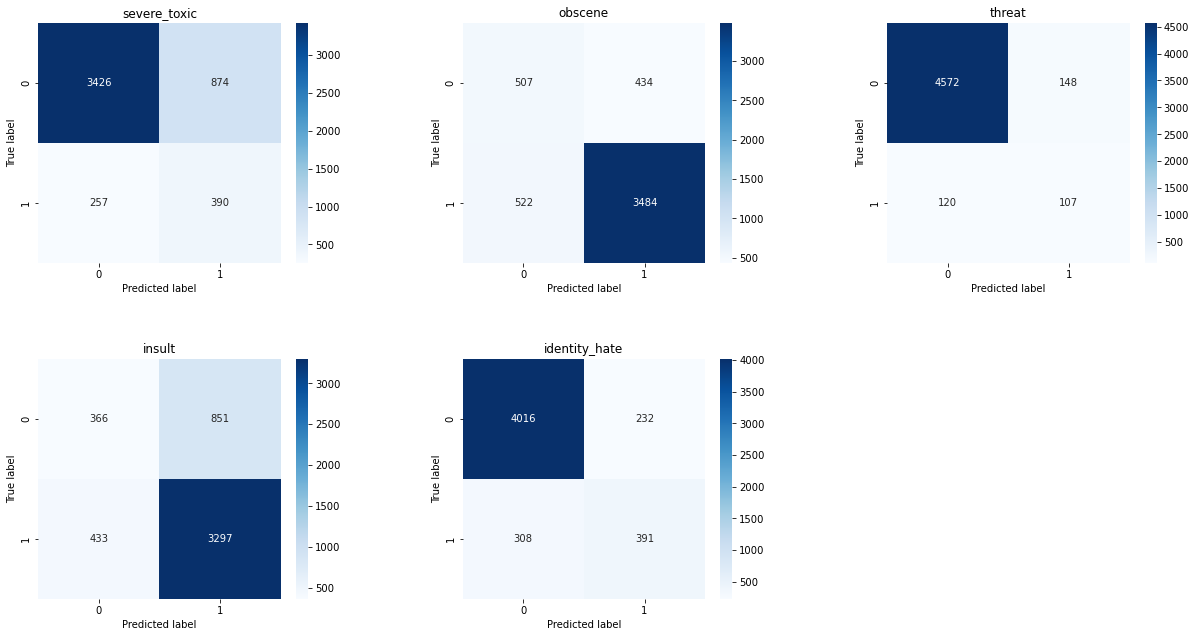

In [28]:
plot_cf(cf, 'multi_without_toxic', labels)

**Model ne predviđa dobro za klase severe_toxic, threat, i identity hate, što i jesu klase sa najmanjim brojem podataka**

In [29]:
print('Brojnost po klasama na test skupu:')
print(get_label_counts(y_test, labels))

Brojnost po klasama na test skupu:
{'severe_toxic': 647, 'obscene': 4006, 'threat': 227, 'insult': 3730, 'identity_hate': 699}


In [30]:
# print(metrics.classification_report(y_test, y_labels,target_names=labels))

Preciznost, odziv i F1 mera za svaku klasu:

In [31]:
precisions, recalls, f1_scores = get_prec_rec_f1(cf, labels)

In [32]:
precisions

{'severe_toxic': 0.31,
 'obscene': 0.89,
 'threat': 0.42,
 'insult': 0.79,
 'identity_hate': 0.63}

In [33]:
recalls

{'severe_toxic': 0.6,
 'obscene': 0.87,
 'threat': 0.47,
 'insult': 0.88,
 'identity_hate': 0.56}

In [34]:
f1_scores

{'severe_toxic': 0.41,
 'obscene': 0.88,
 'threat': 0.44,
 'insult': 0.83,
 'identity_hate': 0.59}

In [41]:
# izracunate metrike se cuvaju u csv datoteku: 

report1 = pd.DataFrame(precisions, index=['precision'])
report2 = pd.DataFrame(recalls, index=['recall'])
report3 = pd.DataFrame(f1_scores, index=['f1'])

report = pd.concat([report1, report2, report3])

report.to_csv('data/report3.csv')

In [35]:
new_comments = ['i will kill you', 'go die', 'you are so stupid', 'You suck!']
new = to_sequence(new_comments, 100, tokenizer)

probs = multi_model.predict(new)

predictions = []

for prob in probs:
    rounded = [round(p) for p in prob]
    predictions.append(rounded)
        
model_preds = pd.DataFrame(predictions, columns=labels)
model_preds['comment'] = new_comments

In [36]:
print('Predvidjanja za nove komentare: ')
model_preds

Predvidjanja za nove komentare: 


,severe_toxic,obscene,threat,insult,identity_hate,comment
0,0,0,1,0,0,i will kill you
1,0,0,1,1,0,go die
2,0,0,0,1,0,you are so stupid
3,0,1,0,1,0,You suck!


### Čuvanje modela

In [39]:
multi_model.save_weights('models/multi_model_weights1.hdf5')
multi_model.save('models/multi_model1.hdf5')

In [ ]:
# model = keras.models.load_model('models/multi_model.hdf5', custom_objects={"f1_m": f1_m})
# plot_model(model, to_file='plots and images/multi_model.png', show_shapes=True) 
# model.get_config()